# BASE

## Clases plotting y simulación


### Simulación

In [17]:
import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess
from scipy.stats import norm, t, uniform, gamma, gaussian_kde
from statsmodels.tsa.ar_model import AutoReg
from sklearn.utils import resample

class TimeSeriesSimulator:
    def __init__(self, phi, theta, noise_dist, sigma, n=250, burn_in=50):
        self.phi = np.array(phi)
        self.theta = np.array(theta)
        self.noise_dist = noise_dist
        self.sigma = sigma
        self.n = n
        self.burn_in = burn_in
        self.series = None
        self.noise = None
        
    def generate_noise(self):
        """Genera ruido según la distribución especificada con media 0 y varianza sigma²"""
        n_total = self.n + self.burn_in
        
        if self.noise_dist == 'normal':
            noise = np.random.normal(0, self.sigma, n_total)
            
        elif self.noise_dist == 'uniform':
            a = -np.sqrt(3)*self.sigma
            b = np.sqrt(3)*self.sigma
            noise = np.random.uniform(a, b, n_total)
            
        elif self.noise_dist == 'exponential':
            # Y ~ Exp(1/σ) ajustado para media 0
            exp_samples = gamma.rvs(1, scale=self.sigma, size=n_total)
            noise = exp_samples - self.sigma
            
        elif self.noise_dist == 't':
            # Grados de libertad para varianza finita (n > 2)
            nu = 18  # Según especificación del paper
            scale = self.sigma * np.sqrt((nu - 2)/nu)
            noise = t.rvs(df=nu, scale=scale, size=n_total)
            
        elif self.noise_dist == 'mixture':
            # Mezcla de normales: 25% N(-3σ, σ²) + 75% N(3σ, σ²)
            components = np.random.choice([-3, 3], size=n_total, p=[0.25, 0.75])
            noise = norm.rvs(loc=components*self.sigma, scale=self.sigma)
            
        else:
            raise ValueError("Distribución no soportada")
            
        return noise
    
    def simulate_arma(self):
        """Simula proceso ARMA con parámetros especificados"""
        noise = self.generate_noise()
        
        # Configurar modelo ARMA
        ar = np.r_[1, -self.phi] if len(self.phi) > 0 else [1]
        ma = np.r_[1, self.theta] if len(self.theta) > 0 else [1]
        
        # Función generadora de ruido compatible con statsmodels
        def noise_generator(size):
            return np.random.choice(noise, size=size, replace=True)
        
        arma = ArmaProcess(ar=ar, ma=ma)
        full_series = arma.generate_sample(
            nsample=self.n + self.burn_in,
            scale=1,
            distrvs=noise_generator
        )
        
        # Descartar burn-in y guardar serie limpia
        self.series = full_series[self.burn_in:]
        self.noise = noise[self.burn_in:self.burn_in + self.n]
        return self.series
    
    def densidad_real(self, h=1, n_boot=500, p_max=10):
        """
        Estima densidad de pronóstico usando Sieve Bootstrap
        h: horizonte de pronóstico
        n_boot: número de muestras bootstrap
        p_max: orden máximo AR para selección de modelo
        """
        # 1. Selección de modelo AR(p)
        aic_values = []
        for p in range(0, p_max+1):
            model = AutoReg(self.series, lags=p, old_names=False)
            results = model.fit()
            aic_values.append(results.aic)
            
        best_p = np.argmin(aic_values)
        
        # 2. Estimación Yule-Walker
        model = AutoReg(self.series, lags=best_p, old_names=False)
        results = model.fit()
        phi_hat = results.params[1:]
        residuals = results.resid
        
        # 3. Centrar residuos
        centered_resid = residuals - np.mean(residuals)
        
        # 4. Bootstrap de pronósticos
        forecasts = []
        for _ in range(n_boot):
            # Remuestreo de residuos
            boot_resid = resample(centered_resid, replace=True)
            
            # Construir serie bootstrap
            boot_series = np.copy(self.series)
            for t in range(best_p, len(self.series)):
                ar_part = np.dot(phi_hat, boot_series[t-best_p:t][::-1])
                boot_series[t] = ar_part + boot_resid[t-best_p]
                
            # Pronóstico recursivo
            last_obs = boot_series[-best_p:]
            forecast = []
            for _ in range(h):
                next_val = np.dot(phi_hat, last_obs[::-1]) + np.random.choice(centered_resid)
                forecast.append(next_val)
                last_obs = np.roll(last_obs, -1)
                last_obs[-1] = next_val
                
            forecasts.extend(forecast)
        
        # 5. Estimación de densidad kernel
        kde = gaussian_kde(forecasts)
        return kde

### Plotting

In [18]:
import matplotlib.pyplot as plt

class PlotManager:
    @staticmethod
    def plot_series(series, title="Serie Temporal Simulada"):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 5))
        plt.plot(series, label="Serie Simulada", color='#1f77b4', linewidth=1.2, alpha=0.8)
        plt.title(title, fontsize=14, pad=20)
        plt.xlabel("Tiempo", fontsize=12)
        plt.ylabel("Valor", fontsize=12)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_single_distribution(real_noise, predictions, model_name, metric, title):
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        plt.figure(figsize=(10, 5))
        
        # Configuración de colores
        colors = {
            'Real': '#d62728',
            'Modelo': '#1f77b4'
        }
        
        # Graficar densidad real
        sns.kdeplot(real_noise, color=colors['Real'], label='Ruido Real', linewidth=2)
        
        # Graficar densidad del modelo si hay predicciones
        if len(predictions) > 0:
            sns.kdeplot(predictions, color=colors['Modelo'], label=model_name, linewidth=2, linestyle='--')
        
        # Configuración del gráfico
        plt.title(title, fontsize=14)
        plt.xlabel("Valor", fontsize=12)
        plt.ylabel("Densidad", fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Cuadro de métrica
        text_str = f'ECRPS: {metric:.4f}' if not np.isnan(metric) else 'ECRPS: N/A'
        plt.text(0.95, 0.95, text_str, 
                 transform=plt.gca().transAxes,
                 verticalalignment='top',
                 horizontalalignment='right',
                 bbox=dict(facecolor='white', alpha=0.8))
        
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_all_distributions(real_noise, bootstrap_samples, cp_predictions, 
                            deepar_predictions, qn_dist, metrics, 
                            title="Comparación de Densidades Predictivas"):
        import matplotlib.pyplot as plt
        from scipy.stats import gaussian_kde, norm
        import numpy as np

        plt.figure(figsize=(16, 8))

        # 1. Configuración de colores actualizada
        colors = {
            'Real': '#d62728',        # Rojo
            'Bootstrap': '#ff7f0e',   # Naranja
            'CPnewModel': '#9467bd',  # Morado
            'DeepAR': '#17becf',      # Cyan
            'CPnewModelQn': '#2ca02c' # Verde
        }

        # 2. Función para procesar diferentes formatos de Qn
        def process_qn_data(qn_dist):
            if isinstance(qn_dist, list):
                # Convertir lista de diccionarios a array de valores
                return np.array([d['value'] for d in qn_dist if 'value' in d])
            return qn_dist

        # 3. Función segura para calcular límites
        def safe_percentile(data, perc):
            try:
                clean_data = process_qn_data(data) if isinstance(data, list) else data
                return np.percentile(clean_data, perc) if len(clean_data) > 0 else 0
            except:
                return 0

        # 4. Calcular límites del gráfico considerando todos los modelos
        datasets = [real_noise, bootstrap_samples, cp_predictions, deepar_predictions, qn_dist]
        lower = min([safe_percentile(d, 1) for d in datasets]) - 0.5
        upper = max([safe_percentile(d, 99) for d in datasets]) + 0.5

        # 5. Función de graficación unificada
        def plot_density(data, color, label, is_qn=False):
            try:
                # Procesar datos Qn
                values = process_qn_data(data) if is_qn else data
                
                if len(values) < 2:
                    print(f"Datos insuficientes para {label}")
                    return

                kde = gaussian_kde(values, bw_method=0.25)
                x = np.linspace(max(values.min(), lower), min(values.max(), upper), 500)
                y = kde(x)
                
                plt.plot(x, y, 
                        color=color, 
                        linewidth=2.5, 
                        linestyle='-',
                        alpha=0.9,
                        label=label)
                
                plt.fill_between(x, y, color=color, alpha=0.1)

            except Exception as e:
                print(f"Error graficando {label}: {str(e)}")

        # 6. Graficar en orden específico (Qn último)
        plot_density(real_noise, colors['Real'], 'Real')
        plot_density(bootstrap_samples, colors['Bootstrap'], 'Bootstrap')
        plot_density(cp_predictions, colors['CPnewModel'], 'CPnewModel')
        plot_density(deepar_predictions, colors['DeepAR'], 'DeepAR')
        plot_density(qn_dist, colors['CPnewModelQn'], 'CPnewModelQn', is_qn=True)

        # 7. Configuración de la leyenda
        handles, labels = plt.gca().get_legend_handles_labels()
        if handles:
            leg = plt.legend(
                fontsize=11,
                frameon=True,
                framealpha=0.95,
                loc='upper left',
                ncol=2,
                facecolor='white',
                edgecolor='#333333',
                handletextpad=0.5
            )

        # 8. Cuadro de métricas
        if metrics:
            sorted_metrics = sorted(metrics.items(), key=lambda x: x[1].get('ecrps', np.nan))
            text_str = "ECRPS:\n" + '\n'.join(
                [f"• {model}: {val.get('ecrps', np.nan):.4f}" for model, val in sorted_metrics]
            )
            
            plt.text(
                0.97, 0.97, text_str,
                transform=plt.gca().transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                fontsize=11,
                bbox=dict(
                    facecolor='white',
                    alpha=0.95,
                    edgecolor='#d62728',
                    linewidth=1.2,
                    boxstyle='round,pad=0.4'
                ),
                fontfamily='monospace'
            )

        # 9. Ajustes finales
        plt.title(title, fontsize=16, pad=20, weight='bold')
        plt.xlabel("Valor del Ruido", fontsize=13, labelpad=10)
        plt.ylabel("Densidad de Probabilidad", fontsize=13, labelpad=10)
        plt.grid(True, linestyle=':', alpha=0.4, color='gray')
        plt.xlim(lower, upper)
        plt.ylim(0, None)
        plt.gca().set_facecolor('#f8f9fa')
        plt.tight_layout()
        plt.show()

## Clases de modelos

### Bootstrapping

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from metrica import ecrps

class BootstrappingModel:
    """Modelo para generar distribuciones predictivas usando bootstrapping"""
    
    def __init__(self, random_state=42, verbose=False):
        self.n_lags = None
        self.random_state = random_state
        self.model = None
        self.mean_val = None
        self.std_val = None
        self.verbose = verbose

    def prepare_data(self, df):
        """Prepara los datos normalizando"""
        values = df['valor'].values
        self.mean_val = np.mean(values)
        self.std_val = np.std(values)
        return (values - self.mean_val) / self.std_val

    def denormalize(self, values):
        """Desnormaliza los valores para volver a la escala original"""
        return values * self.std_val + self.mean_val

    def fit_predict(self, df, n_boot=1000):
        """Ajusta el modelo y genera predicciones bootstrap"""
        normalized_values = self.prepare_data(df)
        # Ajustar modelo AutoReg
        self.model = AutoReg(normalized_values, lags=self.n_lags, old_names=False)
        fitted_model = self.model.fit()

        # Generar predicciones bootstrap
        predictions = fitted_model.forecast(steps=1)
        residuals = fitted_model.resid

        rng = np.random.default_rng(seed=self.random_state)
        boot_predictions = predictions + rng.choice(residuals, size=n_boot, replace=True)

        # Desnormalizar predicciones
        boot_predictions = self.denormalize(boot_predictions)

        return boot_predictions

    def calculate_wasserstein(self, distribution, real_noise):
        """Calcula la distancia de Wasserstein entre dos distribuciones"""
        return ecrps(distribution, real_noise)

    def grid_search(self, df, real_noise, lags_range=range(1, 13), n_boot=500):
        """Búsqueda en malla para encontrar el mejor n_lags usando Wasserstein"""
        best_distance = float('inf')
        best_lag = None

        for n_lags in lags_range:
            self.n_lags = n_lags
            try:
                # Generar distribución predictiva
                distribution = self.fit_predict(df, n_boot=n_boot)
                
                # Calcular distancia con el ruido real
                current_distance = self.calculate_wasserstein(distribution, real_noise)
                
                # Actualizar mejores parámetros
                if current_distance < best_distance:
                    best_distance = current_distance
                    best_lag = n_lags
                    
            except Exception as e:
                # Manejar posibles errores de ajuste del modelo
                continue

        self.n_lags = best_lag
        if self.verbose:
             print(f"✅ Mejor n_lags encontrado: {self.n_lags} (ecrps = {best_distance:.4f})")
       
        return best_lag, best_distance

### CPNewModel

In [54]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Ridge
from bayes_opt import BayesianOptimization
from metrica import ecrps

class CPnewModel:
    """Modelo avanzado para series temporales con optimización bayesiana (versión sin Numba)"""
    
    def __init__(self, n_lags=5, rho=0.95, max_points=10000, alpha=0.1, poly_degree=2, 
                 seasonal_periods=[12], random_state=42, verbose=False):
        self.n_lags = n_lags
        self.rho = rho
        self.max_points = max_points
        self.alpha = alpha
        self.poly_degree = poly_degree
        self.seasonal_periods = seasonal_periods
        self.mean_val = None
        self.std_val = None
        self.trends = []
        self.seasonalities = []
        self.random_state = random_state
        self.verbose = verbose
        np.random.seed(self.random_state)

    def optimize_hyperparameters(self, df, real_noise):
        """
        Optimiza hiperparámetros usando Bayesian Optimization con Wasserstein
        """
        def objective(n_lags, rho, poly_degree):
            try:
                # Conversión y validación de parámetros
                n_lags_int = max(1, int(round(n_lags)))
                rho_bounded = min(0.999, max(0.5, float(rho)))
                poly_degree_int = max(1, int(round(poly_degree)))
                
                # Validar suficiencia de datos
                if len(df) <= n_lags_int * 2:
                    return -float('inf')
                
                # Configurar parámetros temporales
                self.n_lags = n_lags_int
                self.rho = rho_bounded
                self.poly_degree = poly_degree_int
                
                # Generar predicciones
                try:
                    predictions = self.fit_predict(df.copy())
                    
                    # Validar predicciones
                    if np.any(np.isnan(predictions)) or np.any(np.isinf(predictions)):
                        return -float('inf')
                    
                    # Calcular distancia de Wasserstein
                    w_dist = ecrps(predictions, real_noise)
                    
                    # Penalización por parámetros extremos
                    penalty = 0
                    if n_lags_int > 8:  # Penalizar lags muy grandes
                        penalty += 0.1 * (n_lags_int - 8)
                    if rho_bounded > 0.98:  # Penalizar rho muy cercano a 1
                        penalty += 0.1 * (rho_bounded - 0.98) / 0.019
                    
                    return -(w_dist + penalty)  # Minimizar distancia total
                    
                except Exception as e:
                    print(f"Error en iteración: {str(e)}")
                    return -float('inf')
                    
            except Exception:
                return -float('inf')

        # Configurar el optimizador bayesiano
        optimizer = BayesianOptimization(
            f=objective,
            pbounds={
                'n_lags': (1, 8),
                'rho': (0.7, 0.99),
                'poly_degree': (1, 3)
            },
            random_state=self.random_state,
            verbose=0
        )
        
        # Estrategia de optimización en dos fases
        best_score = -float('inf')
        
        # Fase 1: Exploración amplia
        optimizer.maximize(init_points=10, n_iter=15)
        
        # Fase 2: Búsqueda local
        if optimizer.max:
            best_params = optimizer.max['params']
            optimizer.set_bounds({
                'n_lags': (max(1, best_params['n_lags']-1), min(8, best_params['n_lags']+1)),
                'rho': (max(0.7, best_params['rho']-0.05), min(0.99, best_params['rho']+0.05)),
                'poly_degree': (max(1, best_params['poly_degree']-1), min(3, best_params['poly_degree']+1))
            })
            optimizer.maximize(init_points=5, n_iter=10)

        # Procesar resultados
        if optimizer.max and optimizer.max['target'] > -float('inf'):
            final_params = optimizer.max['params']
            best_wasserstein = -optimizer.max['target'] - final_params.get('penalty', 0)
            
            self.n_lags = max(1, int(round(final_params['n_lags'])))
            self.rho = min(0.999, max(0.5, final_params['rho']))
            self.poly_degree = max(1, int(round(final_params['poly_degree'])))

            if self.verbose:
            
                print("✅ Optimización exitosa:")
                print(f"  • Lags: {self.n_lags}")
                print(f"  • Rho: {self.rho:.3f}")
                print(f"  • Grado polinomial: {self.poly_degree}")
                print(f"  • ecrps: {best_wasserstein:.4f}")
        else:
            self.n_lags = 3
            self.rho = 0.85
            self.poly_degree = 2
            if self.verbose:
                print("⚠️ Optimización fallida. Usando valores por defecto:")
                print(f"  • Lags: {self.n_lags}")
                print(f"  • Rho: {self.rho:.3f}")
                print(f"  • Grado polinomial: {self.poly_degree}")
        
        return self.n_lags, self.rho, self.poly_degree, best_wasserstein

    def decompose_series(self, df):
        """Elimina tendencia y estacionalidades usando numpy arrays"""
        values = df['valor'].values if isinstance(df, pd.DataFrame) else df
        residual = values.copy().astype(np.float64)

        self.trends = []
        self.seasonalities = []

        for period in self.seasonal_periods:
            if len(residual) >= 2 * period:
                result = seasonal_decompose(residual, period=period, model='additive', extrapolate_trend='freq')
                self.trends.append(result.trend.astype(np.float64))
                self.seasonalities.append(result.seasonal.astype(np.float64))
                residual -= np.nan_to_num(result.trend) + np.nan_to_num(result.seasonal)

        return np.nan_to_num(residual)

    def recombine_components(self, predictions):
        """Agrega componentes estructurales usando numpy"""
        trend_sum = sum(trend[-1] for trend in self.trends if trend is not None and len(trend) > 0)
        seasonal_sum = sum(season[-1] for season in self.seasonalities if season is not None and len(season) > 0)
        return predictions + trend_sum + seasonal_sum

    def _create_lag_matrix(self, values, n_lags, degree=2):
        """Crea matriz de rezagos con términos polinomiales (versión sin Numba)"""
        n = len(values) - n_lags
        X = np.ones((n, 1), dtype=np.float64)
        for lag in range(n_lags):
            lagged = values[lag:lag + n].reshape(-1, 1).astype(np.float64)
            X = np.hstack((X, lagged))
            if degree > 1:
                for d in range(2, degree + 1):
                    X = np.hstack((X, np.power(lagged, d)))
        return X

    def prepare_data(self, df):
        """Preprocesamiento robusto con numpy"""
        detrended_values = self.decompose_series(df)
        detrended_values = np.nan_to_num(detrended_values)
        self.mean_val = np.mean(detrended_values)
        self.std_val = np.std(detrended_values)
        return (detrended_values - self.mean_val) / (self.std_val + 1e-8)

    def adaptive_regularization(self, X):
        """Regularización adaptativa basada en SVD"""
        _, s, _ = np.linalg.svd(X.astype(np.float64))
        condition_number = s[0] / (s[-1] + 1e-10)
        return min(1.0, 1 / (condition_number + 1e-5))

    def calculate_C_values(self, X, y):
        """Calcula los valores C con Ridge"""
        alpha = self.adaptive_regularization(X)
        model = Ridge(alpha=alpha, fit_intercept=False)
        model.fit(X.astype(np.float64), y.astype(np.float64))
        y_pred = model.predict(X)
        residuals = y - y_pred
        XtX_inv = np.linalg.pinv(X.T @ X + alpha * np.eye(X.shape[1]))
        return y_pred + (X @ XtX_inv @ X.T @ residuals)

    def apply_weights(self, C):
        """Aplica pesos exponenciales con numpy puro"""
        weights = self.rho ** np.arange(len(C)-1, -1, -1, dtype=np.float64)
        weights /= np.sum(weights)
        scale_factor = min(self.max_points / np.sum(weights), 100)
        repeats = np.maximum(np.round(weights * scale_factor), 1).astype(int)
        return np.repeat(C.astype(np.float64), repeats)

    def fit_predict(self, df):
        """Genera predicciones con manejo robusto de tipos de datos"""
        try:
            # Convertir a numpy array si es necesario
            if isinstance(df, pd.DataFrame):
                df = df['valor'].values.astype(np.float64)
            
            normalized = self.prepare_data(df)
            
            # Validar longitud suficiente
            if len(normalized) < self.n_lags + self.poly_degree:
                return np.zeros(self.max_points, dtype=np.float64)
            
            X = self._create_lag_matrix(normalized, self.n_lags, self.poly_degree)
            y = normalized[self.n_lags:].astype(np.float64)
            
            # Calcular valores C
            C = self.calculate_C_values(X, y)
            
            # Aplicar pesos y desnormalizar
            weighted = self.apply_weights(C)
            denormalized = (weighted * self.std_val) + self.mean_val
            
            return self.recombine_components(denormalized)
            
        except Exception as e:
            print(f"Error en fit_predict: {str(e)}")
            return np.zeros(self.max_points, dtype=np.float64)

### CPNewModelQn

In [56]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Ridge
from bayes_opt import BayesianOptimization
from metrica import ecrps
from sklearn.utils import check_random_state
from scipy.linalg import pinvh

class CPnewModelQn:
    def __init__(self, n_lags=5, rho=0.95, max_points=1000, alpha=0.1, poly_degree=2, 
                 seasonal_periods=None, random_state=42, ma_order=1, verbose=False):
        self.n_lags = n_lags
        self.rho = rho
        self.max_points = max_points
        self.alpha = alpha
        self.poly_degree = poly_degree
        self.seasonal_periods = seasonal_periods if seasonal_periods is not None else []
        self.mean_val = None
        self.std_val = None
        self.ma_order = ma_order
        self.trend_models = []
        self.seasonal_models = []
        self.random_state = random_state
        self.rng = check_random_state(random_state)
        self.verbose = verbose
        np.random.seed(random_state)

    def optimize_hyperparameters(self, df, real_noise):
            def objective(n_lags, rho, poly_degree, ma_order):
                try:
                    n_lags = int(round(n_lags))
                    ma_order = int(round(ma_order))
                    rho = np.clip(rho, 0.5, 0.99)
                    poly_degree = int(round(poly_degree))
                    
                    max_seasonal = max(self.seasonal_periods) if self.seasonal_periods else 0
                    if len(df) < 2 * (n_lags + ma_order) + 2 * max_seasonal:
                        return -1e12
                    
                    self.n_lags = n_lags
                    self.rho = rho
                    self.poly_degree = poly_degree
                    self.ma_order = ma_order
                    
                    distribution = self.fit_predict(df)
                    if not distribution:
                        return -1e12
                    
                    values = np.array([d['value'] for d in distribution])
                    probs = np.array([d['probability'] for d in distribution])
                    samples = self.rng.choice(values, size=1000, p=probs/probs.sum())
                    
                    min_len = min(len(samples), len(real_noise))
                    return -ecrps(samples[:min_len], real_noise[:min_len])
                
                except Exception as e:
                    return -1e12

            optimizer = BayesianOptimization(
                f=objective,
                pbounds={
                    'n_lags': (3, 5),
                    'rho': (0.6, 0.97),
                    'poly_degree': (1, 2),
                    'ma_order': (1, 2)
                },
                random_state=self.random_state,
                allow_duplicate_points=True,
                verbose=0
            )
            
            try:
                optimizer.maximize(init_points=5, n_iter=10)
                if optimizer.max:
                    best = optimizer.max['params']
                    self.n_lags = int(round(best['n_lags']))
                    self.rho = best['rho']
                    self.poly_degree = int(round(best['poly_degree']))
                    self.ma_order = int(round(best['ma_order']))
                    best_wd = -optimizer.max['target']
                    if self.verbose:
                        print(f"\n✅ Optimización exitosa:\n  • Lags: {self.n_lags}\n  • MA Order: {self.ma_order}\n  • Rho: {self.rho:.3f}\n  • Grado polinomial: {self.poly_degree}\n  • ecrps: {best_wd:.4f}")
            except Exception as e:
                print(f"Error en optimización: {str(e)}")
            
            return self.n_lags, self.rho, self.poly_degree, self.ma_order, best_wd


    def _decompose(self, series):
        residual = series.copy()
        self.trend_models = []
        self.seasonal_models = []
        
        for period in self.seasonal_periods:
            if len(residual) < 2 * period:
                continue
            
            try:
                decomp = seasonal_decompose(residual, period=period, model='additive', extrapolate_trend='freq')
                trend = decomp.trend
                seasonal = decomp.seasonal
                
                # Modelado de tendencia
                X = np.arange(len(trend)).reshape(-1, 1)
                valid = ~np.isnan(trend)
                if np.sum(valid) > 1:
                    model = Ridge(alpha=self.alpha).fit(X[valid], trend[valid])
                    trend_pred = model.predict(X)
                else:
                    trend_pred = np.zeros_like(trend)
                
                # Modelado estacional
                seasonal_model = np.zeros(period)
                seasonal_indices = np.tile(np.arange(period), len(residual) // period + 1)[:len(residual)]
                for i in range(period):
                    mask = seasonal_indices == i
                    if np.any(mask):
                        seasonal_model[i] = np.nanmean(seasonal[mask])
                seasonal_series = seasonal_model[seasonal_indices]
                
                residual = residual - trend_pred - seasonal_series
                self.trend_models.append(model if np.sum(valid) > 1 else None)
                self.seasonal_models.append(seasonal_model)
            except Exception as e:
                print(f"Error en descomposición: {e}")
                continue
        
        residual = np.nan_to_num(residual, nan=np.nanmedian(residual))
        return residual

    def _calculate_C(self, X, y, weights):
        model = Ridge(alpha=self.alpha, fit_intercept=False)
        model.fit(X, y, sample_weight=weights)
        y_pred = model.predict(X)
        return y_pred

    def _Qn_distribution(self, C, original_length):  # <- Parámetro añadido
        sorted_C = np.sort(C)
        n = len(sorted_C)
        distribution = []
        
        # Usar original_length para predicción
        next_trend = sum(
            model.predict([[original_length + 1]])[0]  # <- original_length usado aquí
            for model in self.trend_models 
            if model is not None
        )
        next_seasonal = sum(
            model[(len(C)+1) % len(model)] 
            for model in self.seasonal_models 
            if len(model) > 0
        )
        
        # Generar distribución según definición formal
        for i in range(n):
            current_val = sorted_C[i]
            
            # Desnormalizar valor
            denorm = current_val * self.std_val + self.mean_val
            full_value = denorm + next_trend + next_seasonal
            
            # Asignar intervalo según posición
            lower_prob = i / (n + 1)
            upper_prob = (i + 1) / (n + 1)
            
            # Manejar valores duplicados (combinar intervalos)
            if i > 0 and np.isclose(current_val, sorted_C[i-1]):
                # Fusionar con el anterior
                distribution[-1]['probability'] = upper_prob - distribution[-1]['lower']
                distribution[-1]['upper'] = upper_prob
            else:
                distribution.append({
                    'value': full_value,
                    'lower': lower_prob,
                    'upper': upper_prob,
                    'probability': upper_prob - lower_prob
                })
        
        return distribution
    
    def fit_predict(self, df):
        try:
            values = df['valor'].values if isinstance(df, pd.DataFrame) else df
            if len(values) < (self.n_lags + self.ma_order) * 2:
                print("Error: Datos insuficientes para el modelo ARMA.")
                return []
            
            residual = self._decompose(values)
            self.mean_val = np.nanmean(residual)
            self.std_val = np.nanstd(residual) + 1e-8
            normalized = (residual - self.mean_val) / self.std_val
            
            if len(normalized) < self.n_lags + self.ma_order:
                print("Error: Datos insuficientes tras normalización.")
                return []
            
            X = []
            y = []
            errors = np.zeros(len(normalized))
            
            for i in range(self.n_lags, len(normalized)):
                # Componente AR
                ar_start = i - self.n_lags
                ar_features = normalized[ar_start:i]
                if len(ar_features) != self.n_lags:
                    continue
                
                # Características polinómicas AR
                poly_features = np.zeros(self.n_lags * self.poly_degree)
                for d in range(1, self.poly_degree + 1):
                    start = (d-1)*self.n_lags
                    end = d*self.n_lags
                    poly_features[start:end] = ar_features ** d
                
                # Componente MA
                ma_start = i - self.ma_order
                if ma_start >= 0:
                    ma_errors = errors[ma_start:i]
                else:
                    ma_errors = np.zeros(self.ma_order)
                
                # Combinar características
                full_features = np.concatenate([poly_features, ma_errors])
                X.append(full_features)
                y.append(normalized[i])
                
                # Actualizar errores
                if len(X) >= 1:
                    current_X = np.array(X[-1]).reshape(1, -1)
                    current_pred = self._calculate_C(current_X, np.array([0]), np.array([1]))[0]
                    errors[i] = normalized[i] - current_pred
            
            if not X:
                print("Error: No se generaron características válidas.")
                return []
            
            X = np.array(X)
            y = np.array(y)
            
            if len(y) == 0:
                return []
            
            weights = self.rho ** np.arange(len(y))[::-1]
            weights /= weights.sum() + 1e-8
            
            C = self._calculate_C(X, y, weights)
            
            return self._Qn_distribution(C, original_length=len(values))
        
        except Exception as e:
            print(f"Error crítico en fit_predict: {str(e)}")
            return []


### DeepAR

In [69]:
 
import numpy as np
import pandas as pd
from metrica import ecrps
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

# Verificar disponibilidad de PyTorch
TORCH_AVAILABLE = False
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    TORCH_AVAILABLE = True
except ImportError:
    pass

class DeepARModel:
    """DeepAR modificado para optimización con Wasserstein Distance"""
    
    def __init__(self, hidden_size=20, n_lags=5, num_layers=1, dropout=0.1,
                 lr=0.01, batch_size=32, epochs=100, num_samples=1000, random_state=42, verbose=False):
        self.hidden_size = hidden_size
        self.n_lags = n_lags
        self.num_layers = num_layers
        self.dropout = dropout
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.num_samples = num_samples
        self.model = None
        self.scaler_mean = None
        self.scaler_std = None
        self.random_state = random_state
        self.verbose = verbose
        self.best_params = None

        np.random.seed(random_state)
        if TORCH_AVAILABLE:
            torch.manual_seed(random_state)

    class _DeepARNN(nn.Module):
        """Arquitectura neuronal de DeepAR"""
        def __init__(self, input_size, hidden_size, num_layers, dropout):
            super().__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                               batch_first=True, dropout=dropout)
            self.fc_mu = nn.Linear(hidden_size, 1)
            self.fc_sigma = nn.Linear(hidden_size, 1)

        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            last_out = lstm_out[:, -1, :]
            mu = self.fc_mu(last_out)
            sigma = torch.exp(self.fc_sigma(last_out))
            return mu, sigma

    def _create_sequences(self, series):
        """Crea secuencias para entrenamiento"""
        X, y = [], []
        for i in range(len(series) - self.n_lags):
            X.append(series[i:i + self.n_lags])
            y.append(series[i + self.n_lags])
        return np.array(X), np.array(y)

    def _train_model(self, X_train, y_train):
        """Entrenamiento del modelo con PyTorch"""
        if not TORCH_AVAILABLE:
            return None

        X_tensor = torch.FloatTensor(X_train.reshape(-1, self.n_lags, 1))
        y_tensor = torch.FloatTensor(y_train.reshape(-1, 1))

        model = self._DeepARNN(1, self.hidden_size, self.num_layers, self.dropout)
        criterion = nn.GaussianNLLLoss()
        optimizer = optim.Adam(model.parameters(), lr=self.lr)

        model.train()
        for epoch in range(self.epochs):
            permutation = torch.randperm(X_tensor.size(0))
            for i in range(0, X_tensor.size(0), self.batch_size):
                indices = permutation[i:i + self.batch_size]
                batch_x, batch_y = X_tensor[indices], y_tensor[indices]

                mu, sigma = model(batch_x)
                loss = criterion(mu, batch_y, sigma)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch + 1}/{self.epochs}], Loss: {loss.item():.4f}')

        return model

    def calculate_wasserstein(self, predictions, real_values):
        """Calcula la distancia de Wasserstein entre distribuciones"""
        return ecrps(predictions, real_values)
    
    def optimize_hyperparameters(self, df, real_noise):
        """Optimización bayesiana que devuelve parámetros y ECRPS"""
        if not TORCH_AVAILABLE:
            print("PyTorch no disponible. No se puede optimizar DeepAR.")
            return None, np.nan

        best_ecrps = np.nan
        best_params = None

        def objective(n_lags, hidden_size, num_layers, dropout, lr):
            nonlocal best_ecrps, best_params
            self.n_lags = max(1, int(n_lags))
            self.hidden_size = max(5, int(hidden_size))
            self.num_layers = max(1, int(num_layers))
            self.dropout = min(0.5, max(0.0, dropout))
            self.lr = max(0.0001, lr)

            try:
                predictions = self.fit_predict(df.copy())
                
                # Calcular ECRPS
                current_ecrps = self.calculate_wasserstein(predictions, real_noise)
                
                # Actualizar mejores valores si corresponde
                if current_ecrps < best_ecrps or np.isnan(best_ecrps):
                    best_ecrps = current_ecrps
                    best_params = {
                        'n_lags': self.n_lags,
                        'hidden_size': self.hidden_size,
                        'num_layers': self.num_layers,
                        'dropout': self.dropout,
                        'lr': self.lr
                    }
                
                return -current_ecrps  # Minimizar el ECRPS
                
            except Exception as e:
                print(f"Error en optimización: {str(e)}")
                return -float('inf')

        optimizer = BayesianOptimization(
            f=objective,
            pbounds={
                'n_lags': (1, 10),
                'hidden_size': (5, 30),
                'num_layers': (1, 3),
                'dropout': (0.0, 0.5),
                'lr': (0.001, 0.1)
            },
            random_state=self.random_state,
            verbose=0
        )

        optimizer.maximize(init_points=3, n_iter=7)

        # Procesar resultados
        if optimizer.max:
            # Obtener el mejor ECRPS de la optimización
            best_ecrps = -optimizer.max['target']
            best_params = {
                'n_lags': max(1, int(optimizer.max['params']['n_lags'])),
                'hidden_size': max(5, int(optimizer.max['params']['hidden_size'])),
                'num_layers': max(1, int(optimizer.max['params']['num_layers'])),
                'dropout': min(0.5, max(0.0, optimizer.max['params']['dropout'])),
                'lr': max(0.0001, optimizer.max['params']['lr'])
            }
            
            if self.verbose:
                print("✅ Optimización DeepAR Exitosa:")
                print(f"  • ECRPS: {best_ecrps:.4f}")
                print(f"  • Lags: {best_params['n_lags']}")
                print(f"  • Hidden Size: {best_params['hidden_size']}")
                print(f"  • Capas LSTM: {best_params['num_layers']}")
                print(f"  • Dropout: {best_params['dropout']:.3f}")
                print(f"  • Learning Rate: {best_params['lr']:.4f}")

        self.best_params = best_params
        
        return best_params, best_ecrps

    def fit_predict(self, df):
        """Genera predicciones con manejo robusto de errores"""
        try:
            # Preparación de datos
            series = df['valor'].values if isinstance(df, pd.DataFrame) else df
            self.scaler_mean = np.nanmean(series)
            self.scaler_std = np.nanstd(series)
            normalized_series = (series - self.scaler_mean) / (self.scaler_std + 1e-8)

            # Crear secuencias
            X_train, y_train = self._create_sequences(normalized_series)
            
            if TORCH_AVAILABLE and self.model is not None:
                # Entrenar modelo con PyTorch
                self.model = self._train_model(X_train, y_train)

                # Generar predicciones
                last_sequence = normalized_series[-self.n_lags:].reshape(1, self.n_lags, 1)
                last_sequence_tensor = torch.FloatTensor(last_sequence)
                
                self.model.eval()
                with torch.no_grad():
                    mu, sigma = self.model(last_sequence_tensor)
                    mu = mu.item()
                    sigma = sigma.item()
                    
                # Muestrear distribución normal
                samples = np.random.normal(mu, sigma, self.num_samples)
            else:
                # Fallback a aproximación gaussiana simple
                if len(y_train) > 0:
                    mu = np.nanmean(y_train)
                    sigma = np.nanstd(y_train)
                else:
                    mu = 0
                    sigma = 1
                samples = np.random.normal(mu, sigma, self.num_samples)

            # Desnormalizar y asegurar tipos de datos
            predictions = (samples * self.scaler_std + self.scaler_mean).astype(np.float64)
            predictions = np.nan_to_num(predictions, nan=0.0, posinf=0.0, neginf=0.0)
            
            return predictions
            
        except Exception as e:
            print(f"Error crítico en fit_predict: {str(e)}")
            return np.zeros(self.num_samples, dtype=np.float64)


    def evaluate_model(self, predictions, real_values):
        """Evaluación completa del modelo"""
        metrics = {
            'Energy Score': self.calculate_wasserstein(predictions, real_values)
        }
        return metrics

## Clases de orden

### Pipeline

In [23]:
import numpy as np
import pandas as pd
from metrica import ecrps

class Pipeline:
    def __init__(self, name, phi, theta, noise_dist='normal', sigma=1.0, 
                 n=1000, burn_in=100, seed=300, all_visual=True, all_metrics=True):
        """
        Pipeline completo para comparación de modelos de pronóstico
        
        Args:
            name: Nombre identificativo del escenario
            phi: Coeficientes AR (lista)
            theta: Coeficientes MA (lista)
            noise_dist: Tipo de distribución del ruido
            sigma: Volatilidad del proceso
            n: Longitud de la serie temporal
            burn_in: Muestras de burn-in
            seed: Semilla para reproducibilidad
            all_visual: Mostrar visualizaciones completas
            all_metrics: Mostrar métricas completas
        """
        self.name = name
        self.phi = phi if phi is not None else []
        self.theta = theta if theta is not None else []
        self.noise_dist = noise_dist
        self.sigma = sigma
        self.n = n
        self.burn_in = burn_in
        self.seed = seed
        self.all_visual = all_visual
        self.all_metrics = all_metrics
        
        # Configuración de modelos
        self.models = {
            'Bootstrap': BootstrappingModel(random_state=seed),
            'CPnewModel': CPnewModel(random_state=seed),
            'CPnewModelQn': CPnewModelQn(random_state=seed),
            'DeepAR': DeepARModel(random_state=seed, num_samples=1000)
        }
        
        # Configuración de estado
        np.random.seed(seed)
        self.hyperparams = []
        self.predictions = {}
        self.metrics = {}
        self.series = None
        self.true_density = None  # Densidad real del Sieve Bootstrap

    def run(self):
        """Ejecuta el flujo completo del pipeline"""
        # 1. Simulación de datos
        simulator = TimeSeriesSimulator(
            phi=self.phi,
            theta=self.theta,
            noise_dist=self.noise_dist,
            sigma=self.sigma,
            n=self.n,
            burn_in=self.burn_in
        )
        self.series = simulator.simulate_arma()
        
        # 2. Generar densidad real con Sieve Bootstrap
        self.true_density = simulator.densidad_real(h=1, n_boot=2000)
        
         # 3. Procesamiento de modelos
        df = pd.DataFrame({'valor': self.series})
        
        for model_name, model in self.models.items():
            print(f"\n{'='*30} {model_name} {'='*30}")
            
            # Optimización de hiperparámetros y obtención de ECRPS
            self._optimize_model(model, model_name, df)
            
            # Generación de predicciones
            self._generate_predictions(model, model_name, df)
        
        
        # 5. Visualización
        if self.all_visual or self.all_metrics:
            self._visualize_results()
            
        return self

    def _optimize_model(self, model, model_name, df):
            """Optimización específica para cada modelo almacenando ECRPS"""
            try:
                if model_name == 'Bootstrap':
                    best_lag, best_ecrps = model.grid_search(df, self.true_density)
                    params = {'n_lags': best_lag}
                    self.metrics[model_name] = {'ecrps': best_ecrps}
                    
                elif model_name == 'CPnewModel':
                    lags, rho, degree, best_ecrps = model.optimize_hyperparameters(df, self.true_density)
                    params = {'n_lags': lags, 'rho': rho, 'poly_degree': degree}
                    self.metrics[model_name] = {'ecrps': best_ecrps}
                    
                elif model_name == 'CPnewModelQn':
                    lags, rho, degree, ma_order, best_ecrps = model.optimize_hyperparameters(df, self.true_density)
                    params = {'n_lags': lags, 'rho': rho, 'poly_degree': degree, 'ma_order': ma_order}
                    self.metrics[model_name] = {'ecrps': best_ecrps}
                    
                elif model_name == 'DeepAR':
                    best_params, best_ecrps = model.optimize_hyperparameters(df, self.true_density)
                    params = {
                        'n_lags': best_params['n_lags'],
                        'hidden_size': best_params['hidden_size'],
                        'num_layers': best_params['num_layers'],
                        'dropout': best_params['dropout'],
                        'lr': best_params['lr']
                    }
                    self.metrics[model_name] = {'ecrps': best_ecrps}
                    
                self.hyperparams.append({'Modelo': model_name, **params})
                
            except Exception as e:
                print(f"Error en optimización de {model_name}: {str(e)}")
                self.hyperparams.append({'Modelo': model_name, 'Error': str(e)})
                self.metrics[model_name] = {'ecrps': np.nan}

    def _generate_predictions(self, model, model_name, df):
        """Genera predicciones con parámetros optimizados"""
        try:
            if model_name == 'CPnewModelQn':
                distribution = model.fit_predict(df)
                values = np.array([d['value'] for d in distribution])
                probs = np.array([d['probability'] for d in distribution])
                probs /= probs.sum()
                self.predictions[model_name] = np.random.choice(values, size=1000, p=probs)
                
            elif model_name == 'DeepAR':
                preds = model.fit_predict(df)
                self.predictions[model_name] = preds.flatten()
                
            else:
                preds = model.fit_predict(df)
                self.predictions[model_name] = preds.flatten() if hasattr(preds, 'flatten') else preds
                
        except Exception as e:
            print(f"Error en generación de predicciones para {model_name}: {str(e)}")
            self.predictions[model_name] = np.array([])


    def _visualize_results(self):
        """Visualización comparativa con densidad real"""
        if self.all_visual:
            x = np.linspace(-5*self.sigma, 5*self.sigma, 1000)
            true_pdf = self.true_density.pdf(x)
            
            plt.figure(figsize=(15, 8))
            plt.plot(x, true_pdf, 'k--', linewidth=3, label='Densidad Real (Sieve)')
            
            for model_name, preds in self.predictions.items():
                if len(preds) == 0:
                    continue
                    
                kde = gaussian_kde(preds)
                plt.plot(x, kde.pdf(x), 
                        label=f"{model_name} (ECRPS={self.metrics[model_name]['ecrps']:.3f})")
            
            plt.title(f"Comparación de Distribuciones - {self.name}", fontsize=14)
            plt.xlabel("Valor", fontsize=12)
            plt.ylabel("Densidad", fontsize=12)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        
        if self.all_metrics:
            print("═" * 55)
            print("Configuración Óptima de Hiperparámetros:")
            hyper_df = pd.DataFrame(self.hyperparams).set_index('Modelo')
            display(hyper_df.style.format({
                'rho': '{:.2f}',
                'alpha': '{:.1e}',
                'dropout': '{:.2f}',
                'lr': '{:.4f}'
            }))

            print("═" * 55)
            print("Comparativa de Rendimiento (ECRPS):")
            metrics_df = pd.DataFrame(self.metrics).T.reset_index(names='Modelo')
            display(metrics_df.sort_values('ecrps').style.format({'ecrps': '{:.4f}'}))

### Escenarios de simulación

In [24]:
class Escenarios:
    """Generador de escenarios para evaluación de modelos ARMA con diferentes configuraciones"""

    def get_scenarios(self):
        """Retorna todos los escenarios generados"""
        scenarios = []
        
        # Definir modelos según tablas del paper
        modelos = [
            {'tipo': 'AR(1)', 'phi': [0.5], 'theta': []},
            {'tipo': 'AR(2)', 'phi': [0.3, 0.4], 'theta': []},
            {'tipo': 'MA(1)', 'phi': [], 'theta': [0.3]},
            {'tipo': 'MA(2)', 'phi': [], 'theta': [0.4, -0.36]},
            {'tipo': 'ARMA(1,1)', 'phi': [0.5], 'theta': [0.85]},
            {'tipo': 'ARMA(2,2)', 'phi': [0.75, -0.125], 'theta': [-1, 0.09]}
        ]
        
        # Definir distribuciones
        distribuciones = ['normal', 'uniform', 'exponential', 't', 'mixture']
        
        # Definir valores de sigma
        sigma_values = [0.2, 0.5, 1, 3]
        
        # Generar escenarios
        for modelo in modelos:
            for distribucion in distribuciones:
                for sigma in sigma_values:
                    scenario = {
                        'name': f"{modelo['tipo']} - {distribucion} - σ={sigma}",
                        'phi': modelo['phi'],
                        'theta': modelo['theta'],
                        'noise_dist': distribucion,
                        'sigma': sigma,
                        'n': 250,
                        'burn_in': 50
                    }
                    scenarios.append(scenario)
        
        return scenarios 

### Escenario runner

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from metrica import ecrps
from tqdm import tqdm

class ScenarioRunner:
    def __init__(self):
        self.escenarios = Escenarios()
        self.all_results = []
        self.model_stats = pd.DataFrame()
        self.scenario_results = pd.DataFrame()
        self.seed = 42
        self.model_colors = {
            'Bootstrap': '#ff7f0e',
            'CPnewModel': '#9467bd',
            'CPnewModelQn': '#2ca02c',
            'DeepAR': '#17becf'
        }

    def run_all_scenarios(self):
        """Ejecuta todos los escenarios y recolecta métricas"""
        scenarios = self.escenarios.get_scenarios()
        
        # Configurar barra de progreso
        with tqdm(total=len(scenarios), desc="Ejecutando escenarios", unit="escenario") as pbar:
            for scenario in scenarios:
                try:
                    # Configurar pipeline sin output
                    pipeline = Pipeline(
                        name=scenario['name'],
                        phi=scenario['phi'],
                        theta=scenario['theta'],
                        noise_dist=scenario['noise_dist'],
                        sigma=scenario['sigma'],
                        n=scenario['n'],
                        burn_in=scenario['burn_in'],
                        seed=self.seed,
                        all_visual=False,
                        all_metrics=False
                    ).run()
                    
                    self._collect_results(pipeline)
                    pbar.set_postfix_str(f"✅ {scenario['name']}")
                    
                except Exception as e:
                    self._handle_error(scenario)
                    pbar.set_postfix_str(f"❌ {scenario['name']}")
                    
                
                pbar.update(1)
        
        self._process_results()
        self._generate_reports()
        return self

    def _collect_results(self, pipeline):
        """Recolecta resultados de un pipeline ejecutado"""
        scenario_result = {
            'Escenario': pipeline.name,
            'Mejor modelo': None,
            'ecrps (Mejor)': np.inf,
            'Bootstrap': np.nan,
            'CPnewModel': np.nan,
            'CPnewModelQn': np.nan,
            'ES_DeepAR': np.nan
        }
        
        # Obtener métricas y determinar el mejor modelo
        for model, metrics in pipeline.metrics.items():
            ecrps_value = metrics.get('ecrps', np.nan)
            scenario_result[model] = ecrps_value
            
            if ecrps_value < scenario_result['ecrps (Mejor)']:
                scenario_result['ecrps (Mejor)'] = ecrps_value
                scenario_result['Mejor modelo'] = model
                
        self.all_results.append(scenario_result)

    def _handle_error(self, scenario):
        """Maneja errores en la ejecución de escenarios"""
        error_result = {
            'Escenario': scenario['name'],
            'Mejor modelo': 'Error',
            'ecrps (Mejor)': np.nan,
            'Bootstrap': np.nan,
            'CPnewModel': np.nan,
            'CPnewModelQn': np.nan,
            'ES_DeepAR': np.nan
        }
        self.all_results.append(error_result)

    def _process_results(self):
        """Procesa todos los resultados recolectados"""
        self.scenario_results = pd.DataFrame(self.all_results)
        
        # Calcular estadísticas de modelos
        stats = []
        for model in self.model_colors.keys():
            model_results = self.scenario_results[model].dropna()
            stats.append({
                'Modelo': model,
                'Victorias': (self.scenario_results['Mejor modelo'] == model).sum(),
                'ECRPS Promedio': model_results.mean(),
                'ECRPS Mínimo': model_results.min(),
                'ECRPS Máximo': model_results.max(),
                'Desviación Estándar': model_results.std()
            })
            
        self.model_stats = pd.DataFrame(stats)

    def _generate_reports(self):
        """Genera reportes y visualizaciones"""
        self._save_to_csv()
        self._plot_victory_distribution()
        
    def _save_to_csv(self):
        """Guarda resultados en archivos CSV"""
        self.scenario_results.to_csv('resultados_escenarios.csv', index=False)
        self.model_stats.to_csv('estadisticas_modelos.csv', index=False)
        
    def _plot_victory_distribution(self):
        """Genera diagrama de distribución de victorias"""
        plt.figure(figsize=(14, 8))
        
        # Ordenar modelos por victorias
        sorted_stats = self.model_stats.sort_values('Victorias', ascending=False)
        
        # Crear gráfico de torta
        wedges, texts, autotexts = plt.pie(
            sorted_stats['Victorias'],
            labels=None,
            autopct=lambda p: f'{p:.1f}%' if p > 5 else '',
            startangle=140,
            colors=[self.model_colors[m] for m in sorted_stats['Modelo']],
            explode=[0.05]*len(sorted_stats),
            shadow=True,
            textprops={'fontsize': 12, 'color': 'white', 'weight': 'bold'}
        )
        
        # Configurar leyenda
        legend_labels = [
            f"{row['Modelo']}: {row['Victorias']} victorias\n" +
            f"ECRPS avg: {row['ECRPS Promedio']:.3f}"
            for _, row in sorted_stats.iterrows()
        ]
        
        plt.legend(
            wedges, legend_labels,
            title="Desempeño de Modelos",
            loc='center left',
            bbox_to_anchor=(1, 0.5),
            fontsize=11,
            title_fontsize=12
        )
        
        plt.title('Distribución de Victorias por Modelo\n(120 Escenarios Evaluados)', 
                 fontsize=14, pad=20, weight='bold')
        plt.tight_layout()
        plt.show()

    def get_detailed_results(self):
        """Retorna resultados detallados con formato"""
        return self.scenario_results.style \
            .background_gradient(subset=['ecrps (Mejor)'], cmap='YlGnBu') \
            .format({
                'ecrps (Mejor)': '{:.4f}',
                'Bootstrap': '{:.4f}',
                'CPnewModel': '{:.4f}',
                'CPnewModelQn': '{:.4f}',
                'ES_DeepAR': '{:.4f}'
            })

    def get_model_statistics(self):
        """Retorna estadísticas de modelos con formato"""
        return self.model_stats.style \
            .bar(subset=['Victorias'], color='#5fba7d') \
            .format({
                'ECRPS Promedio': '{:.3f}',
                'ECRPS Mínimo': '{:.3f}',
                'ECRPS Máximo': '{:.3f}',
                'Desviación Estándar': '{:.3f}'
            })

### Analizador

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

class PerformanceAnalyzer:
    def __init__(self, scenario_runner):
        self.results = scenario_runner.scenario_results
        self.model_colors = scenario_runner.model_colors
        self._prepare_data()
        
    def _prepare_data(self):
        """Prepara los datos para análisis"""
        model_cols = ['Bootstrap', 'CPnewModel', 'CPnewModelQn', 'DeepAR']
        self.df = pd.melt(
            self.results, 
            value_vars=model_cols, 
            var_name='Modelo', 
            value_name='ECRPS'
        )
        
    def run_full_analysis(self):
        """Ejecuta todo el análisis y visualización"""
        self.anova_test()
        self.tukey_test()
        self.plot_boxplots()
        self.comparative_metrics()
        self.wilcoxon_tests()
        
    def anova_test(self):
        """Prueba ANOVA para diferencias significativas"""
        model_groups = [self.df[self.df['Modelo'] == model]['ECRPS'] 
                       for model in self.df['Modelo'].unique()]
        
        f_val, p_val = stats.f_oneway(*model_groups)
        
        print("#" * 50)
        print("Análisis de Varianza (ANOVA)")
        print("#" * 50)
        print(f"F-value: {f_val:.2f}")
        print(f"P-value: {p_val:.4f}")
        
        if p_val < 0.05:
            print("\nConclusión: Existen diferencias significativas entre los modelos (p < 0.05)")
        else:
            print("\nConclusión: No hay diferencias significativas entre los modelos")
        print("\n" + "="*80 + "\n")
        
    def tukey_test(self):
        """Prueba Post-Hoc de Tukey HSD"""
        print("#" * 50)
        print("Comparación por Pares (Tukey HSD)")
        print("#" * 50)
        
        tukey = pairwise_tukeyhsd(
            endog=self.df['ECRPS'],
            groups=self.df['Modelo'],
            alpha=0.05
        )
        
        print(tukey.summary())
        print("\n" + "="*80 + "\n")
        
    def plot_boxplots(self):
        """Visualización de distribución de ECRPS"""
        plt.figure(figsize=(12, 7))
        sns.boxplot(
            x='Modelo', 
            y='ECRPS', 
            data=self.df, 
            palette=self.model_colors,
            showmeans=True,
            meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black'}
        )
        
        plt.title('Distribución de ECRPS por Modelo', fontsize=14, pad=20)
        plt.xlabel('Modelo', fontsize=12)
        plt.ylabel('ECRPS', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.show()
        print("\n" + "="*80 + "\n")
        
    def comparative_metrics(self):
        """Métricas comparativas detalladas"""
        print("#" * 50)
        print("Métricas Comparativas")
        print("#" * 50)
        
        metrics = self.df.groupby('Modelo')['ECRPS'].agg(['mean', 'std', 'median'])
        baseline = metrics.loc['Bootstrap', 'mean']
        metrics['Diff vs Bootstrap (%)'] = ((metrics['mean'] - baseline) / baseline) * 100
        
        print("\nComparación de Rendimiento:")
        print(metrics.sort_values('mean').to_string(float_format="%.4f"))
        print("\n" + "="*80 + "\n")
        
    def wilcoxon_tests(self):
        """Pruebas de Wilcoxon para modelos específicos"""
        print("#" * 50)
        print("Pruebas de Wilcoxon para Modelos Clave")
        print("#" * 50)
        
        # CPnewModel vs Bootstrap
        _, p1 = stats.wilcoxon(
            self.results['CPnewModel'],
            self.results['Bootstrap']
        )
        
        # CPnewModelQn vs DeepAR
        _, p2 = stats.wilcoxon(
            self.results['CPnewModelQn'],
            self.results['DeepAR']
        )
        
        print(f"CPnewModel vs Bootstrap: p = {p1:.4f}")
        print(f"CPnewModelQn vs DeepAR: p = {p2:.4f}")
        
        print("\nInterpretación:")
        print("p < 0.05 indica diferencia estadísticamente significativa")
        print("\n" + "="*80 + "\n")

## Main

✅ Mejor n_lags encontrado: 6 (ecrps = 0.3570)
✅ Optimización exitosa:
  • Lags: 8
  • Rho: 0.703
  • Grado polinomial: 3
  • ecrps: 0.4240

✅ Optimización exitosa:
  • Lags: 5
  • MA Order: 1
  • Rho: 0.906
  • Grado polinomial: 2
  • ecrps: 0.4185
✅ Optimización DeepAR Exitosa:
  • ECRPS: 0.3257
  • Lags: 2
  • Hidden Size: 29
  • Capas LSTM: 1
  • Dropout: 0.208
  • Learning Rate: 0.0209


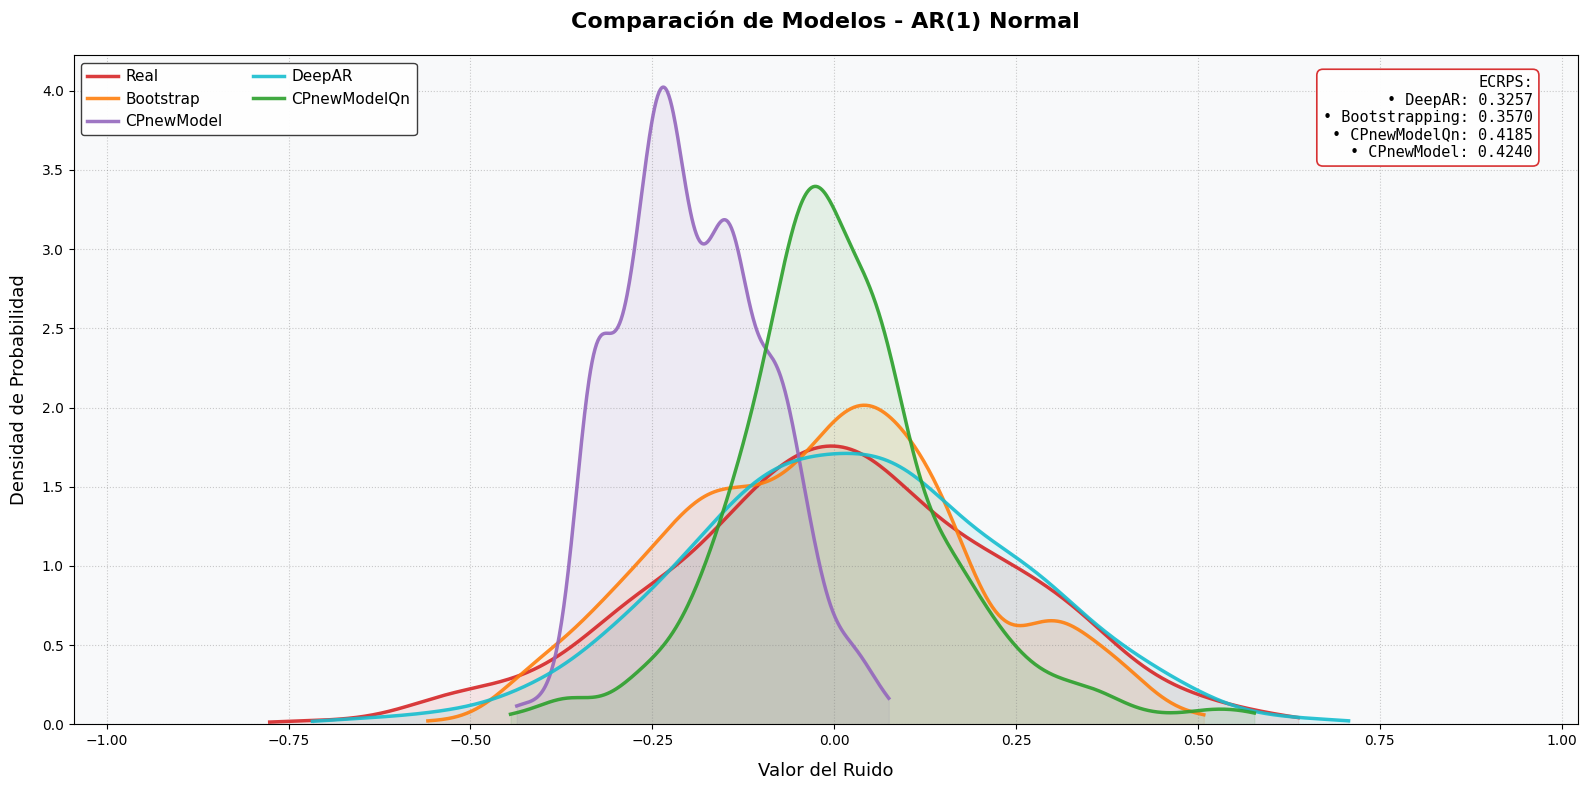

In [70]:
# 1. Simulación de datos
simulador = TimeSeriesSimulator(
    phi=[0.5], 
    theta=[], 
    noise_dist='normal', 
    sigma=0.2
)
serie = simulador.simulate_arma()

# 2. Generar densidad de referencia
kde_real = simulador.densidad_real(n_boot=1000)
muestras_reales = kde_real.resample(1000).flatten()

# 3. Configurar modelos
modelo_bootstrap = BootstrappingModel(random_state=42, verbose=True)
modelo_cp = CPnewModel(random_state=42, verbose=True)
modelo_cp_qn = CPnewModelQn(random_state=42, verbose=True)
modelo_deepar = DeepARModel(random_state=42, verbose=True)

# 4. Optimizar hiperparámetros
# Bootstrapping
mejor_lag, mejor_ecrps_bootstrap = modelo_bootstrap.grid_search(
    pd.DataFrame({'valor': serie}),
    real_noise=muestras_reales,
    lags_range=range(1, 13),
    n_boot=500
)

# CPnewModel
n_lags_cp, rho_cp, poly_degree_cp, mejor_ecrps_cp = modelo_cp.optimize_hyperparameters(
    pd.DataFrame({'valor': serie}),
    real_noise=muestras_reales
)

# CPnewModelQn
n_lags_cp_qn, rho_cp_qn, poly_degree_cp_qn, ma_order_cp_qn, mejor_ecrps_cp_qn = modelo_cp_qn.optimize_hyperparameters(
    pd.DataFrame({'valor': serie}),
    real_noise=muestras_reales,
)

# DeepAR
mejor_params_deepar, mejor_ecrps_deepar = modelo_deepar.optimize_hyperparameters(
    pd.DataFrame({'valor': serie}),
    real_noise=muestras_reales
)

# 5. Generar predicciones
preds_bootstrap = modelo_bootstrap.fit_predict(pd.DataFrame({'valor': serie}), n_boot=1000)
preds_cp = modelo_cp.fit_predict(pd.DataFrame({'valor': serie}))
preds_cp_qn = modelo_cp_qn.fit_predict(pd.DataFrame({'valor': serie}))
preds_deepar = modelo_deepar.fit_predict(pd.DataFrame({'valor': serie}))

# 6. Visualización comparativa
PlotManager.plot_all_distributions(
    real_noise=muestras_reales,
    bootstrap_samples=preds_bootstrap,
    cp_predictions=preds_cp,
    deepar_predictions=preds_deepar,
    qn_dist=preds_cp_qn,
    metrics={
        'Bootstrapping': {'ecrps': mejor_ecrps_bootstrap},
        'CPnewModel': {'ecrps': mejor_ecrps_cp},
        'CPnewModelQn': {'ecrps': mejor_ecrps_cp_qn},
        'DeepAR': {'ecrps': mejor_ecrps_deepar}
    },
    title="Comparación de Modelos - AR(1) Normal"
)


✅ Mejor n_lags encontrado: 12 (ecrps = 0.3594)
✅ Optimización exitosa:
  • Lags: 8
  • Rho: 0.701
  • Grado polinomial: 3
  • ecrps: 0.3779

✅ Optimización exitosa:
  • Lags: 5
  • MA Order: 1
  • Rho: 0.822
  • Grado polinomial: 2
  • ecrps: 0.4283
✅ Optimización DeepAR Exitosa:
  • ECRPS: 0.3296
  • Lags: 1
  • Hidden Size: 11
  • Capas LSTM: 1
  • Dropout: 0.297
  • Learning Rate: 0.0038


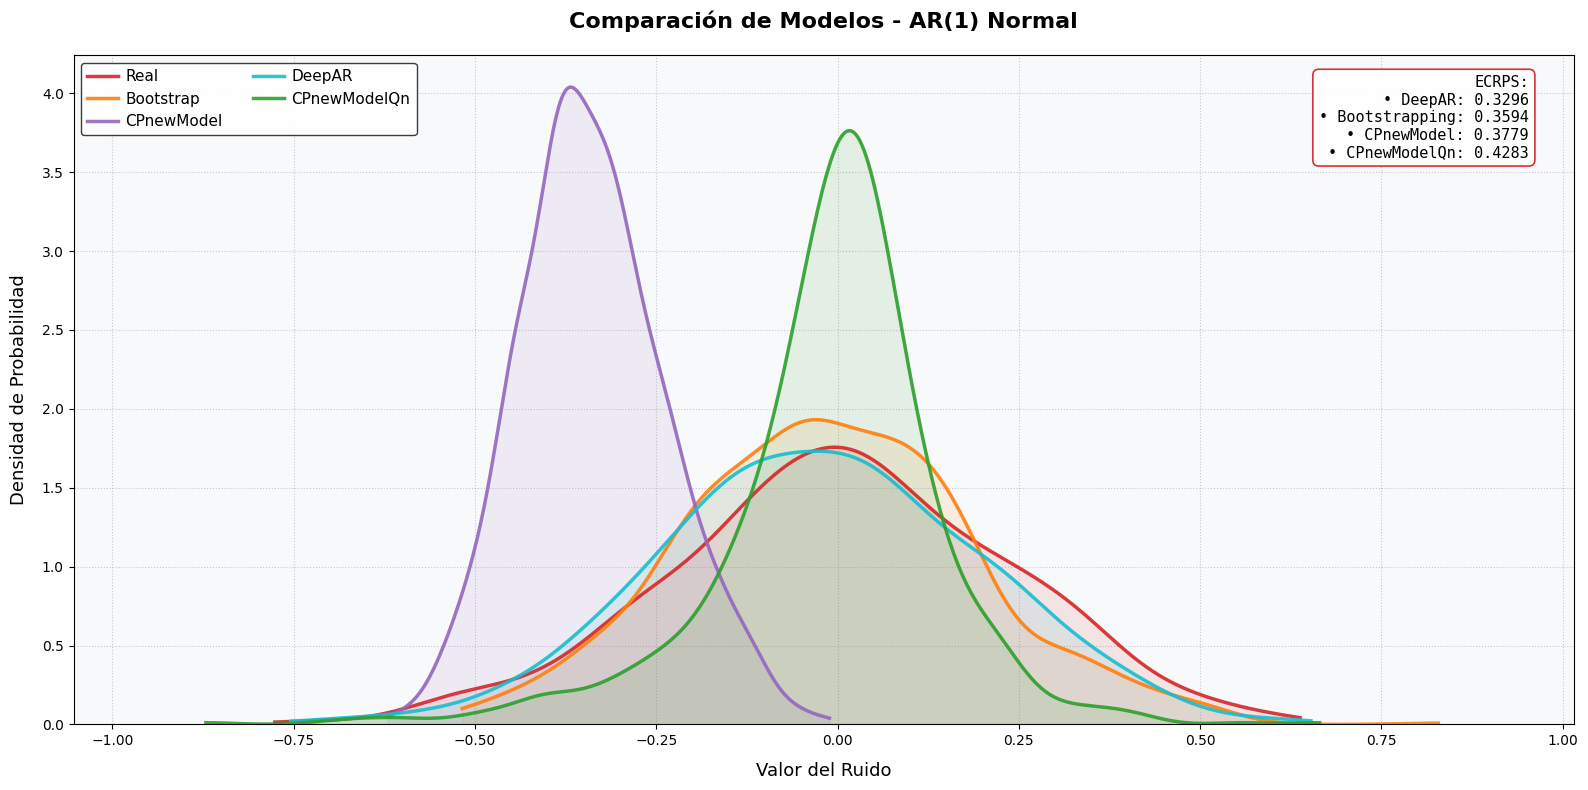

In [76]:
# 1. Simulación del proceso AR(1)
phi = 0.5
sigma = 0.2
n = 1000
burn_in = 100

np.random.seed(2)
errors = np.random.normal(0, sigma, n + burn_in)
serie = np.zeros(n + burn_in)
for t in range(1, n + burn_in):
    serie[t] = phi * serie[t-1] + errors[t]
serie = serie[burn_in:]

# 2. Calcular densidad teórica para y_{n+1}
ultimo_valor = serie[-1]
media_teorica = phi * ultimo_valor
desviacion_teorica = sigma

muestras_teoricas = np.random.normal(
    loc=media_teorica,
    scale=desviacion_teorica,
    size=10000
)


# 3. Configurar modelos
modelo_bootstrap = BootstrappingModel(random_state=42, verbose=True)
modelo_cp = CPnewModel(random_state=42, verbose=True)
modelo_cp_qn = CPnewModelQn(random_state=42, verbose=True)
modelo_deepar = DeepARModel(random_state=42, verbose=True)

# 4. Optimizar hiperparámetros
# Bootstrapping
mejor_lag, mejor_ecrps_bootstrap = modelo_bootstrap.grid_search(
    pd.DataFrame({'valor': serie}),
    real_noise=muestras_reales,
    lags_range=range(1, 13),
    n_boot=500
)

# CPnewModel
n_lags_cp, rho_cp, poly_degree_cp, mejor_ecrps_cp = modelo_cp.optimize_hyperparameters(
    pd.DataFrame({'valor': serie}),
    real_noise=muestras_reales
)

# CPnewModelQn
n_lags_cp_qn, rho_cp_qn, poly_degree_cp_qn, ma_order_cp_qn, mejor_ecrps_cp_qn = modelo_cp_qn.optimize_hyperparameters(
    pd.DataFrame({'valor': serie}),
    real_noise=muestras_reales,
)

# DeepAR
mejor_params_deepar, mejor_ecrps_deepar = modelo_deepar.optimize_hyperparameters(
    pd.DataFrame({'valor': serie}),
    real_noise=muestras_reales
)

# 5. Generar predicciones
preds_bootstrap = modelo_bootstrap.fit_predict(pd.DataFrame({'valor': serie}), n_boot=1000)
preds_cp = modelo_cp.fit_predict(pd.DataFrame({'valor': serie}))
preds_cp_qn = modelo_cp_qn.fit_predict(pd.DataFrame({'valor': serie}))
preds_deepar = modelo_deepar.fit_predict(pd.DataFrame({'valor': serie}))

# 6. Visualización comparativa
PlotManager.plot_all_distributions(
    real_noise=muestras_reales,
    bootstrap_samples=preds_bootstrap,
    cp_predictions=preds_cp,
    deepar_predictions=preds_deepar,
    qn_dist=preds_cp_qn,
    metrics={
        'Bootstrapping': {'ecrps': mejor_ecrps_bootstrap},
        'CPnewModel': {'ecrps': mejor_ecrps_cp},
        'CPnewModelQn': {'ecrps': mejor_ecrps_cp_qn},
        'DeepAR': {'ecrps': mejor_ecrps_deepar}
    },
    title="Comparación de Modelos - AR(1) Normal"
)

In [28]:
# Ejecutar escenarios y análisis
runner = ScenarioRunner().run_all_scenarios()
analyzer = PerformanceAnalyzer(runner)
analyzer.run_full_analysis()

# Acceder a datos crudos si es necesario
raw_data = analyzer.df


Ejecutando escenarios:   0%|          | 0/120 [00:02<?, ?escenario/s]


KeyboardInterrupt: 